## Generate T_amb Profile for Düsseldorf 2016 - pvlib

In [30]:
# For pvlib (data['temp_air'])
import pvlib
import pandas as pd # 'as pd' to change alias from pandas to pd
import matplotlib.pyplot as plt
import pgeocode
import datetime
from datetime import time as settime

# Input
plz = 40599
anlage_groesse = 10 
strom_bedarf = 4000
waerme_bedarf = 20000
year = 2016

# Get Laittude & Longitude
nomi = pgeocode.Nominatim('de') 
a = nomi.query_postal_code(plz)
latitude = a['latitude']
longitude = a['longitude']

# Get hourly solar irradiation and modeled PV power output from PVGIS -> we will only use 'temp_air'
data, meta, inputs = pvlib.iotools.get_pvgis_hourly(latitude, longitude, start=2016, end=2016, surface_tilt=35,
                                                    pvcalculation=True, peakpower=anlage_groesse, mountingplace='building', loss = 0)  

# Set Date as Index for data
data.set_index(pd.date_range(datetime.datetime(year, 1, 1, 0), periods= len(data), freq="h"), inplace=True)

# for Outdoor Air/Water -> T_in_primary and t_amb have the same values --> variable name is temperature
df = pd.DataFrame(data['temp_air']) # from pvgis
df

,temp_air
2016-01-01 00:00:00,4.55
2016-01-01 01:00:00,4.70
2016-01-01 02:00:00,4.84
2016-01-01 03:00:00,4.99
2016-01-01 04:00:00,4.82
...,...
2016-12-31 19:00:00,-1.74
2016-12-31 20:00:00,-1.94
2016-12-31 21:00:00,-2.15
2016-12-31 22:00:00,-2.15


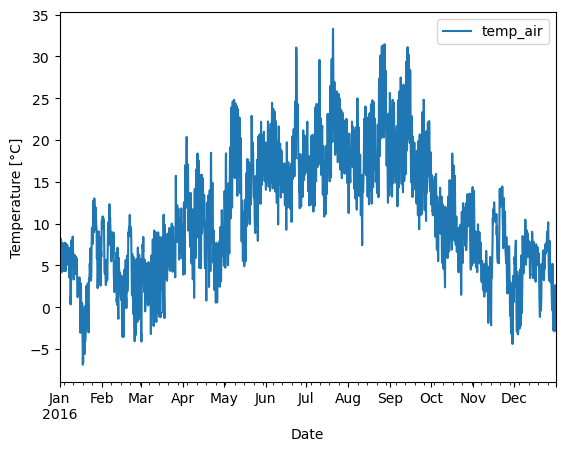

In [31]:
# Plot temperature profile
ax = df.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Temperature [°C]")
plt.show()

## Generate Heat Demand - demandlib

In [32]:
## Wärmeprofil - demandlib ##
import demandlib
from demandlib import bdew
import demandlib.bdew as bdew
import demandlib.particular_profiles as profiles

# Get holidays
from workalendar.europe import Germany
cal = Germany()
year = 2016
holidays = dict(cal.holidays(year))

# # Creates demand Data Frame with Datetime Index, row length matches length of data
# demand = pd.DataFrame(
#     index=pd.date_range(
#         datetime.datetime(year, 1, 1, 0), periods= len(data), freq="h"
#     )
# )

# Single family house only heating (efh: Einfamilienhaus)
df['efh_h'] = bdew.HeatBuilding(
    df.index,
    holidays=holidays,
    temperature=data['temp_air'],
    shlp_type="EFH",
    building_class=1,
    wind_class=1,
    annual_heat_demand=waerme_bedarf,
    name="EFH",
    ww_incl = False
).get_bdew_profile()

# Single family house heating & DHW (efh: Einfamilienhaus)
df['efh_h_dhw'] = bdew.HeatBuilding(
    df.index,
    holidays=holidays,
    temperature=data['temp_air'],
    shlp_type="EFH",
    building_class=1,
    wind_class=1,
    annual_heat_demand=waerme_bedarf,
    name="EFH",
    ww_incl = True
).get_bdew_profile()

df


,temp_air,efh_h,efh_h_dhw
2016-01-01 00:00:00,4.55,2.707422,2.558410
2016-01-01 01:00:00,4.70,2.767057,2.614762
2016-01-01 02:00:00,4.84,2.862473,2.704927
2016-01-01 03:00:00,4.99,3.089085,2.919067
2016-01-01 04:00:00,4.82,3.780849,3.572757
...,...,...,...
2016-12-31 19:00:00,-1.74,7.228014,6.762465
2016-12-31 20:00:00,-1.94,6.899468,6.455080
2016-12-31 21:00:00,-2.15,6.107970,5.714562
2016-12-31 22:00:00,-2.15,4.629513,4.331331


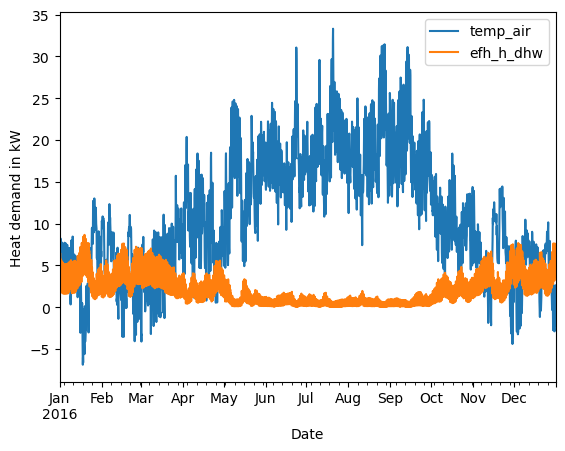

In [33]:
# T_amb vs Heat Profile
p_th = df[['temp_air', 'efh_h_dhw']]
ax = p_th.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Heat demand in kW")
plt.show()

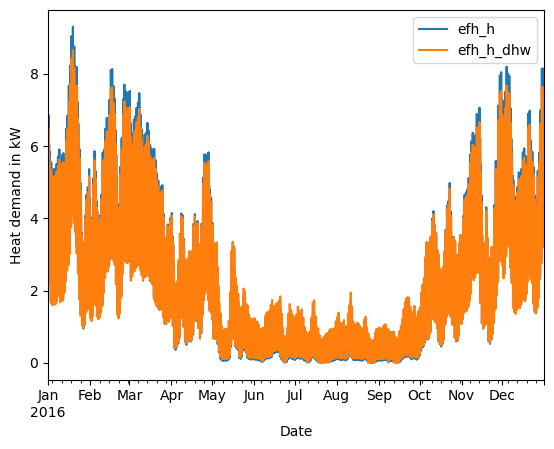

In [34]:
# Plot heat profiles
p_th = df[['efh_h', 'efh_h_dhw']]
ax = p_th.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Heat demand in kW")
plt.show()

## hplib

In [35]:

from hplib import hplib as hpl
from hplib import hplib_database as db
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Findet WP mit gleichen Werten wie Vaillant-Model für die Simulation - simulate funktioniert nur mit database, nicht mit database_all
same = hpl.Same_Built()
hp_vaillant = same.all_to_database(modelname ='VWL 75/6 A 230V')

# Get parameters
parameters_v = hpl.get_parameters(hp_vaillant)
parameters_v

,Manufacturer,Model,MAPE_COP,MAPE_P_el,MAPE_P_th,P_th_h_ref [W],P_el_h_ref [W],COP_ref,Group,p1_P_th [1/°C],...,p3_Pdc [-],p4_Pdc [1/°C],p1_P_el_c [1/°C],p2_P_el_c [1/°C],p3_P_el_c [-],p4_P_el_c [1/°C],p1_EER [-],p2_EER [-],p3_EER [-],p4_EER [-]
0,Saunier Duval Brand Group,HA 7-6 O 230V,12.267727,4.059529,11.147301,5420.0,2545.0,2.13,1.0,-34.903971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Simulation

<Axes: >

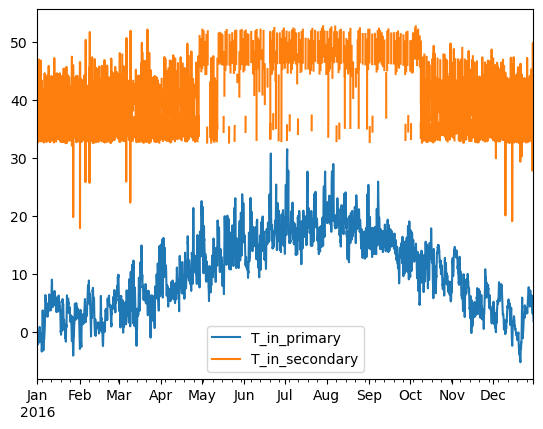

In [58]:
# Get T_in_secondary aus TestYear.csv (aus hplib)
test_year = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\TestYear.csv')

# test_year is in min -> convert to h
year = 2016
test_year.set_index(pd.date_range(datetime.datetime(year, 1, 1, 0), periods= len(test_year), freq="min"), inplace=True)
test_year_h = test_year.resample('h').mean()
test_year_h.plot()

In [59]:
# T_in_secondary in df
df['T_in_secondary'] = test_year_h['T_in_secondary']

In [63]:
#  Create heat pump object with parameters
heatpump_v = hpl.HeatPump(parameters_v)
results = heatpump_v.simulate(t_in_primary=df['temp_air'].values, t_in_secondary=df['T_in_secondary'].values, t_amb=df['temp_air'].values, mode=1)
results_df = pd.DataFrame.from_dict(results)
results_df.set_index(pd.date_range(datetime.datetime(year, 1, 1, 0), periods= len(results_df), freq="h"), inplace=True)
results_df

,T_in,T_out,T_amb,COP,EER,P_el,P_th,m_dot
2016-01-01 00:00:00,4.55,38.408824,4.55,4.544282,0,600.042246,2726.761196,0.129846
2016-01-01 01:00:00,4.70,40.270000,4.70,4.398550,0,618.344686,2719.820150,0.129515
2016-01-01 02:00:00,4.84,41.870270,4.84,4.275056,0,632.507963,2704.007039,0.128762
2016-01-01 03:00:00,4.99,39.144444,4.99,4.549120,0,565.937006,2574.515233,0.122596
2016-01-01 04:00:00,4.82,41.900000,4.82,4.269055,0,635.995901,2715.101650,0.129291
...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,-1.74,NaN,-1.74,NaN,0,NaN,NaN,NaN
2016-12-31 20:00:00,-1.94,NaN,-1.94,NaN,0,NaN,NaN,NaN
2016-12-31 21:00:00,-2.15,NaN,-2.15,NaN,0,NaN,NaN,NaN
2016-12-31 22:00:00,-2.15,NaN,-2.15,NaN,0,NaN,NaN,NaN


In [68]:
# Append reults_df to df
df['T_out'] = results_df['T_out']
df['COP'] = results_df['COP']
df['EER'] = results_df['EER']
df['P_el'] = results_df['P_el']
df['P_th'] = results_df['P_th']
df['m_dot'] = results_df['m_dot']

# P_th in kW wie efh
df['P_th_kW'] = results_df['P_th'].div(1000)
df

,temp_air,efh_h,efh_h_dhw,T_in_secondary,T_out,COP,EER,P_el,P_th,m_dot,P_th_kW
2016-01-01 00:00:00,4.55,2.707422,2.558410,33.408824,38.408824,4.544282,0,600.042246,2726.761196,0.129846,2.726761
2016-01-01 01:00:00,4.70,2.767057,2.614762,35.270000,40.270000,4.398550,0,618.344686,2719.820150,0.129515,2.719820
2016-01-01 02:00:00,4.84,2.862473,2.704927,36.870270,41.870270,4.275056,0,632.507963,2704.007039,0.128762,2.704007
2016-01-01 03:00:00,4.99,3.089085,2.919067,34.144444,39.144444,4.549120,0,565.937006,2574.515233,0.122596,2.574515
2016-01-01 04:00:00,4.82,3.780849,3.572757,36.900000,41.900000,4.269055,0,635.995901,2715.101650,0.129291,2.715102
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,-1.74,7.228014,6.762465,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2016-12-31 20:00:00,-1.94,6.899468,6.455080,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2016-12-31 21:00:00,-2.15,6.107970,5.714562,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2016-12-31 22:00:00,-2.15,4.629513,4.331331,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN


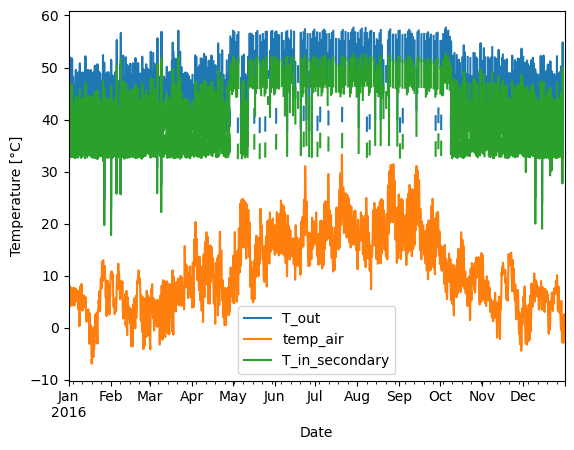

In [66]:
# Plot T_in & T_out
temp=df[['T_out', 'temp_air', 'T_in_secondary']]
ax = temp.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Temperature [°C]")
plt.show()

COP_Mittelwert:  4.6
The seasonal performance factor (SPF) for one year is = 4.4


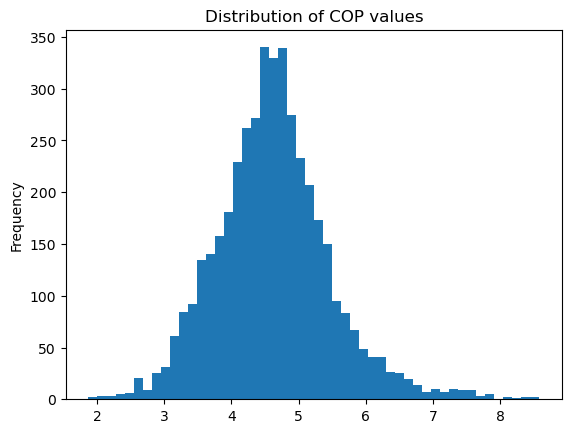

In [67]:
# Generic
# Plot COP Distribution
df['COP'].plot.hist(bins=50, title='Distribution of COP values') 

# Mean COP
print('COP_Mittelwert: ', round(df['COP'].mean(), 1))

# Calclulate seasonal performance factor (SPF)
SPF = df['P_th'].mean() / df['P_el'].mean() 
print('The seasonal performance factor (SPF) for one year is = '+str(round(SPF,1)))

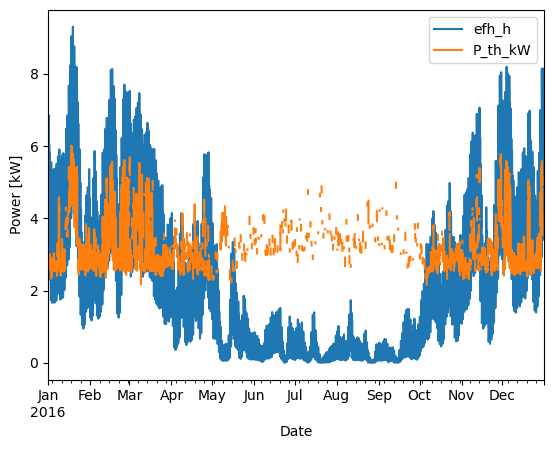

In [72]:
# Plot efh & P_th_kW
heat=df[['efh_h', 'P_th_kW']]
ax = heat.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Power [kW]")
plt.show()

In [73]:
df['efh_h'].sum()

20001.396639151757

In [74]:
df['P_th_kW'].sum()

14208.825863247137